### Data Dictionary

The success of marketing campaigns can be highly specific to the product, the target audience, and the campaign methods. In this problem, we examine data from direct marketing campaigns of a Portuguese banking institution between May 2008 and November 2010. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be or not subscribed.

In this analysis, the goal would be predicting the dependent variable y, which takes value 1 if the the client subscribed to a term deposit, and 0 otherwise. The data we will be using bank.csv is a subset of the original data, containing 5000 examples and 20 input variables. The variable information is as follows:


    age
    job - type of job
    marital - marital status
    education - Shows the level of education of each customer
    default - Whether a customer has credit in default
    housing - Does the customer have a housing loan?
    loan - Does the customer have a personal loan?
    contact - The contact communication type
    month - Last contact month of year
    day_of_week - Last contact day of Week
    duration - Last contact duration in seconds (Note: this variable is not known before making the call)
    campaign - Number of contact performed for the client during the campaign
    pdays - number of days that passed by after the client was last contacted from a previous campaign (value of 999 means the client was not previously contacted)
    previous - number of contacts performed before this campaign and for this client
    poutcome - outcome of the previous marketing campaign
    emp.var.rate - employment variation rate - quarterly indicator
    cons.price.idx - consumer price index - monthly indicator
    cons.conf.idx - consumer confidence index - monthly indicator
    euribor3m - euribor 3 month rate - daily indicator
    nr.employed - number of employees - quarterly indicator


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

np.random.seed = 0

### Data Exploration

In [2]:
df = pd.read_csv("bank.csv")

In [3]:
df

,age,job,marital,education,default,housing,loan,contact,month,dayofweek,duration,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
0,52,admin,single,university.degree,unknown,unknown,unknown,cellular,aug,wed,138,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
1,49,blue-collar,divorced,high.school,no,no,yes,telephone,may,mon,742,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,25,blue-collar,single,basic.9y,no,yes,yes,cellular,jul,wed,322,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
3,27,admin,single,university.degree,no,no,no,telephone,oct,tue,540,1,999,0,nonexistent,-0.1,93.798,-40.4,4.860,5195.8,1
4,44,admin,married,university.degree,no,yes,no,cellular,aug,wed,113,1,999,0,nonexistent,-2.9,92.201,-31.4,0.879,5076.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,37,technician,divorced,professional.course,no,yes,no,cellular,aug,tue,520,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0
4996,39,blue-collar,divorced,high.school,no,yes,yes,telephone,may,tue,163,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0
4997,28,services,single,professional.course,no,no,no,telephone,may,thu,210,2,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,0
4998,32,admin,single,university.degree,unknown,no,no,cellular,aug,tue,240,5,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           5000 non-null   int64  
 1   job           5000 non-null   object 
 2   marital       5000 non-null   object 
 3   education     5000 non-null   object 
 4   default       5000 non-null   object 
 5   housing       5000 non-null   object 
 6   loan          5000 non-null   object 
 7   contact       5000 non-null   object 
 8   month         5000 non-null   object 
 9   dayofweek     5000 non-null   object 
 10  duration      5000 non-null   int64  
 11  campaign      5000 non-null   int64  
 12  pdays         5000 non-null   int64  
 13  previous      5000 non-null   int64  
 14  poutcome      5000 non-null   object 
 15  empvarrate    5000 non-null   float64
 16  conspriceidx  5000 non-null   float64
 17  consconfidx   5000 non-null   float64
 18  euribor3m     5000 non-null 

In [5]:
df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,dayofweek,duration,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
count,5000.000000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000000,5000.00000,5000.000000,5000.000000,5000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
unique,NaN,12,4,8,2,3,3,2,10,5,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,admin,married,university.degree,no,yes,no,cellular,may,thu,NaN,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1260,3026,1457,3998,2604,4144,3149,1680,1047,NaN,NaN,NaN,NaN,4296,NaN,NaN,NaN,NaN,NaN,NaN
mean,39.581400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.173400,2.53760,958.682000,0.177800,NaN,0.05834,93.569322,-40.538980,3.596636,5166.480940,0.118200
std,10.254112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.436793,2.81776,196.012383,0.505013,NaN,1.58084,0.577387,4.606221,1.742869,71.908468,0.322877
min,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.00000,0.000000,0.000000,NaN,-3.40000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.000000,1.00000,999.000000,0.000000,NaN,-1.80000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.000000,2.00000,999.000000,0.000000,NaN,1.10000,93.444000,-41.800000,4.857000,5191.000000,0.000000
75%,46.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.000000,3.00000,999.000000,0.000000,NaN,1.40000,93.994000,-36.400000,4.961000,5228.100000,0.000000


In [6]:
df.shape

(5000, 21)

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'dayofweek', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'empvarrate', 'conspriceidx', 'consconfidx',
       'euribor3m', 'nremployed', 'y'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

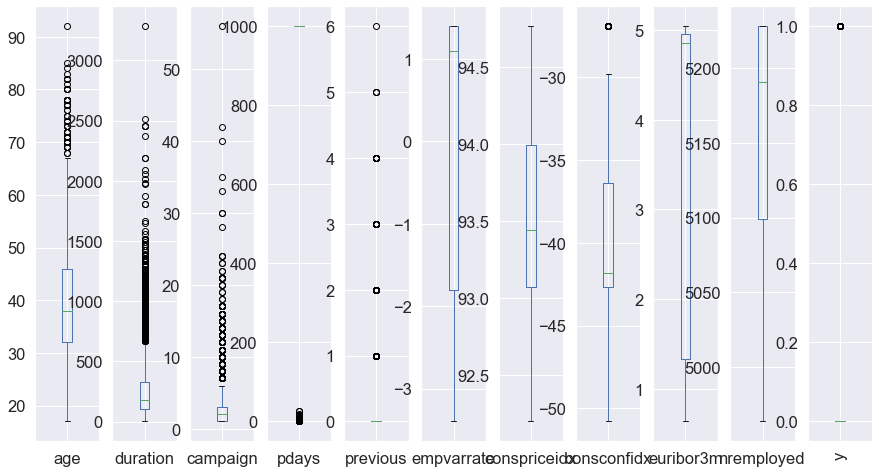

In [8]:
df.plot(kind='box', subplots = True, figsize=(15,8))
plt.xticks(rotation=90)
plt.show()

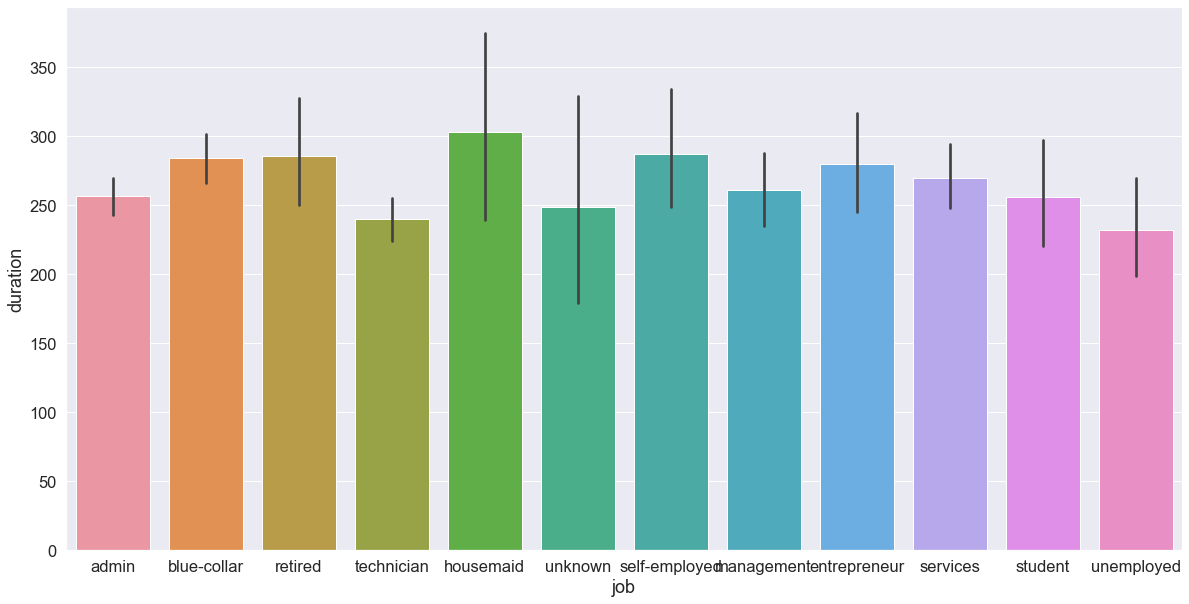

In [9]:
fig = plt.figure(figsize=(20,10))
sns.barplot(x=df.job,y=df.duration)
plt.show()

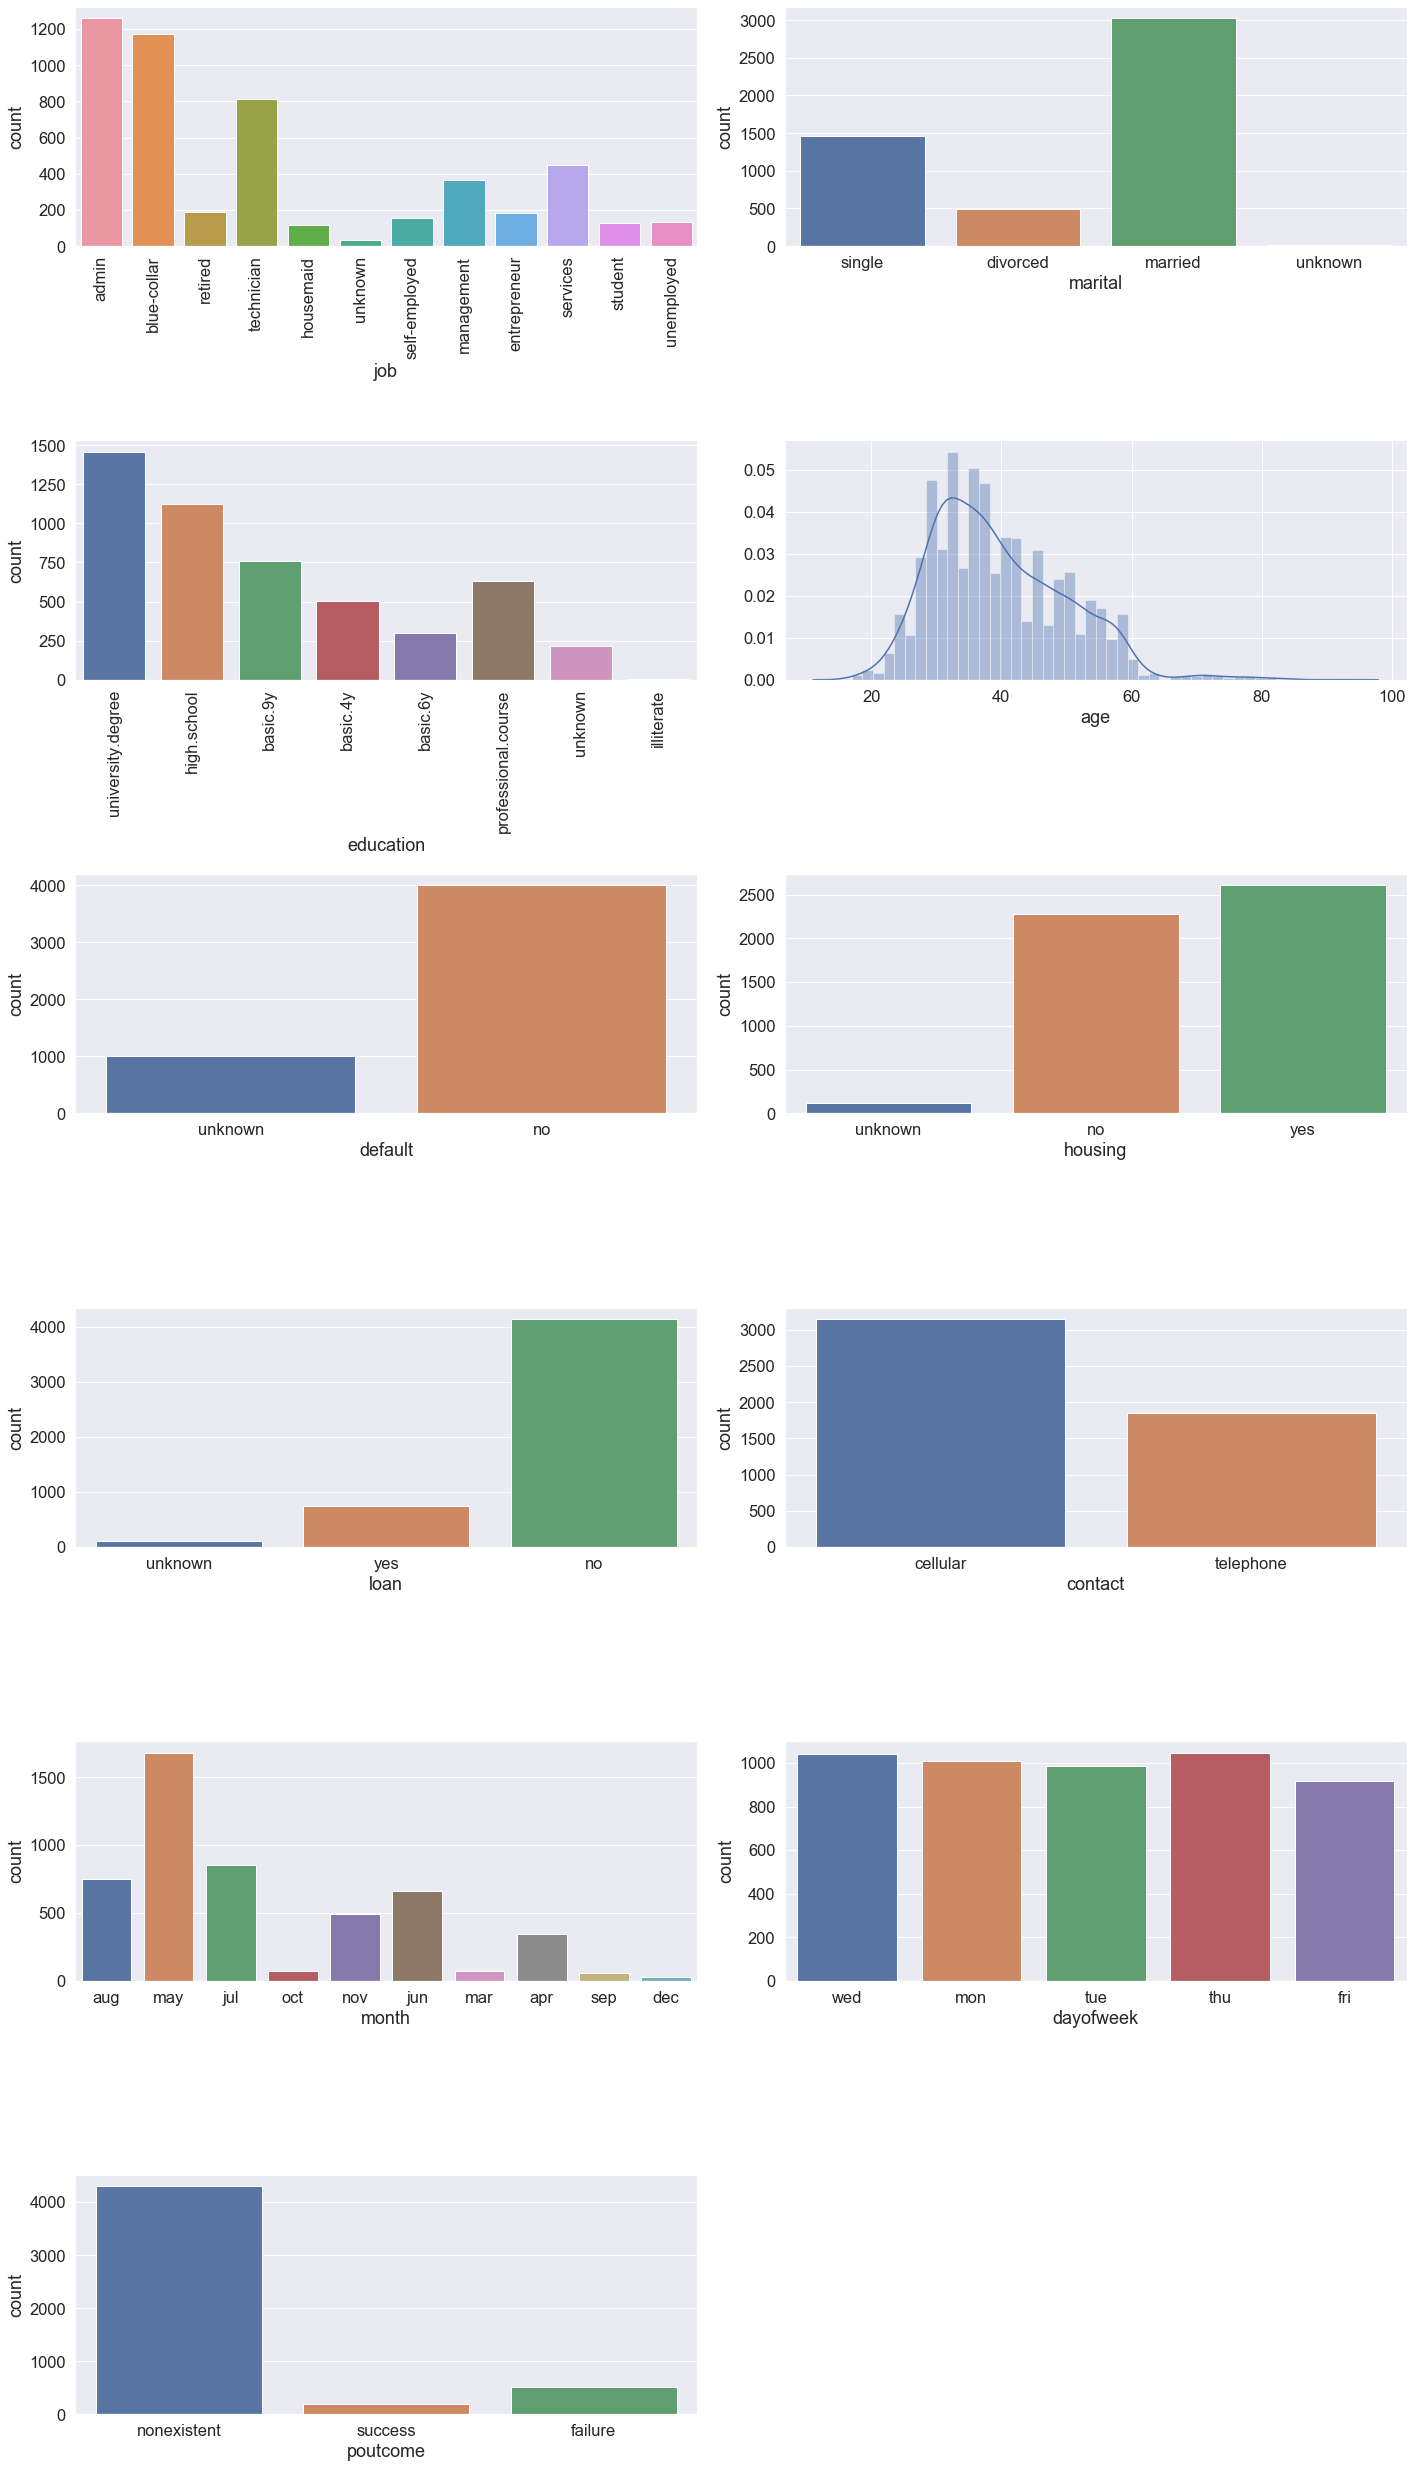

In [10]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.job)
plt.xticks(rotation=90)

plt.subplot(7,2,2)
sns.countplot(df.marital)

plt.subplot(7,2,3)
sns.countplot(df.education)
plt.xticks(rotation=90)

plt.subplot(7,2,4)
sns.distplot(df.age)

plt.subplot(7,2,5)
sns.countplot(df.default)

plt.subplot(7,2,6)
sns.countplot(df.housing)

plt.subplot(7,2,7)
sns.countplot(df.loan)

plt.subplot(7,2,8)
sns.countplot(df.contact)

plt.subplot(7,2,9)
sns.countplot(df.month)

plt.subplot(7,2,10)
sns.countplot(df.dayofweek)

plt.subplot(7,2,11)
sns.countplot(df.poutcome)

# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [11]:
df.corr()

,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
age,1.000000,0.012877,0.013093,-0.005890,0.015109,0.021766,0.023526,0.147523,0.030674,-0.000095,0.033194
duration,0.012877,1.000000,-0.059866,-0.024757,-0.002889,-0.015400,-0.000816,-0.000913,-0.020094,-0.022183,0.417691
campaign,0.013093,-0.059866,1.000000,0.056910,-0.077869,0.141388,0.132087,-0.018162,0.127330,0.133316,-0.057986
pdays,-0.005890,-0.024757,0.056910,1.000000,-0.607989,0.285702,0.092343,-0.072758,0.307627,0.375316,-0.285644
previous,0.015109,-0.002889,-0.077869,-0.607989,1.000000,-0.415960,-0.200207,-0.058214,-0.447481,-0.494072,0.199872
empvarrate,0.021766,-0.015400,0.141388,0.285702,-0.415960,1.000000,0.780879,0.204491,0.973299,0.914130,-0.279349
conspriceidx,0.023526,-0.000816,0.132087,0.092343,-0.200207,0.780879,1.000000,0.079211,0.700070,0.545222,-0.150200
consconfidx,0.147523,-0.000913,-0.018162,-0.072758,-0.058214,0.204491,0.079211,1.000000,0.282205,0.099709,0.022763
euribor3m,0.030674,-0.020094,0.127330,0.307627,-0.447481,0.973299,0.700070,0.282205,1.000000,0.947981,-0.292917
nremployed,-0.000095,-0.022183,0.133316,0.375316,-0.494072,0.914130,0.545222,0.099709,0.947981,1.000000,-0.321879


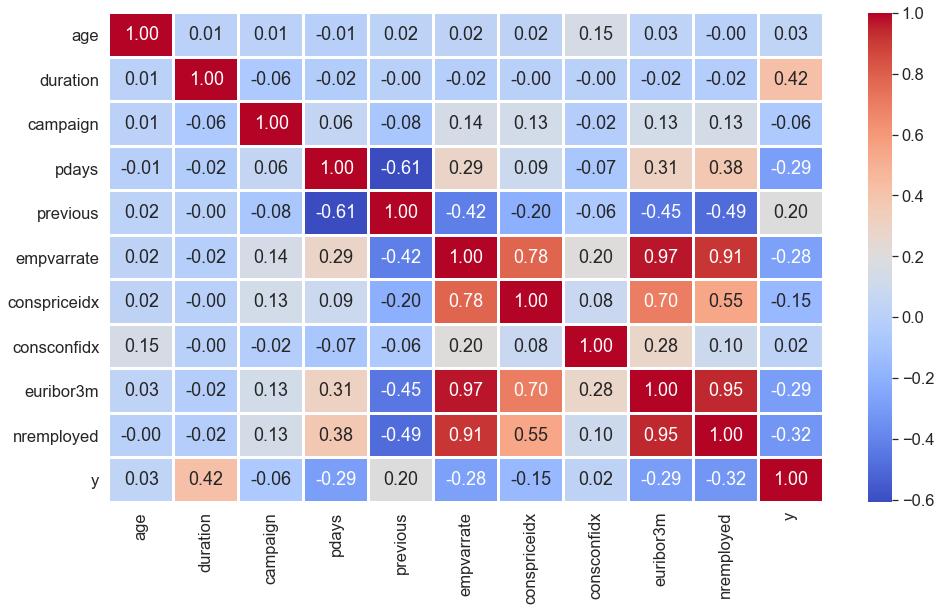

In [12]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

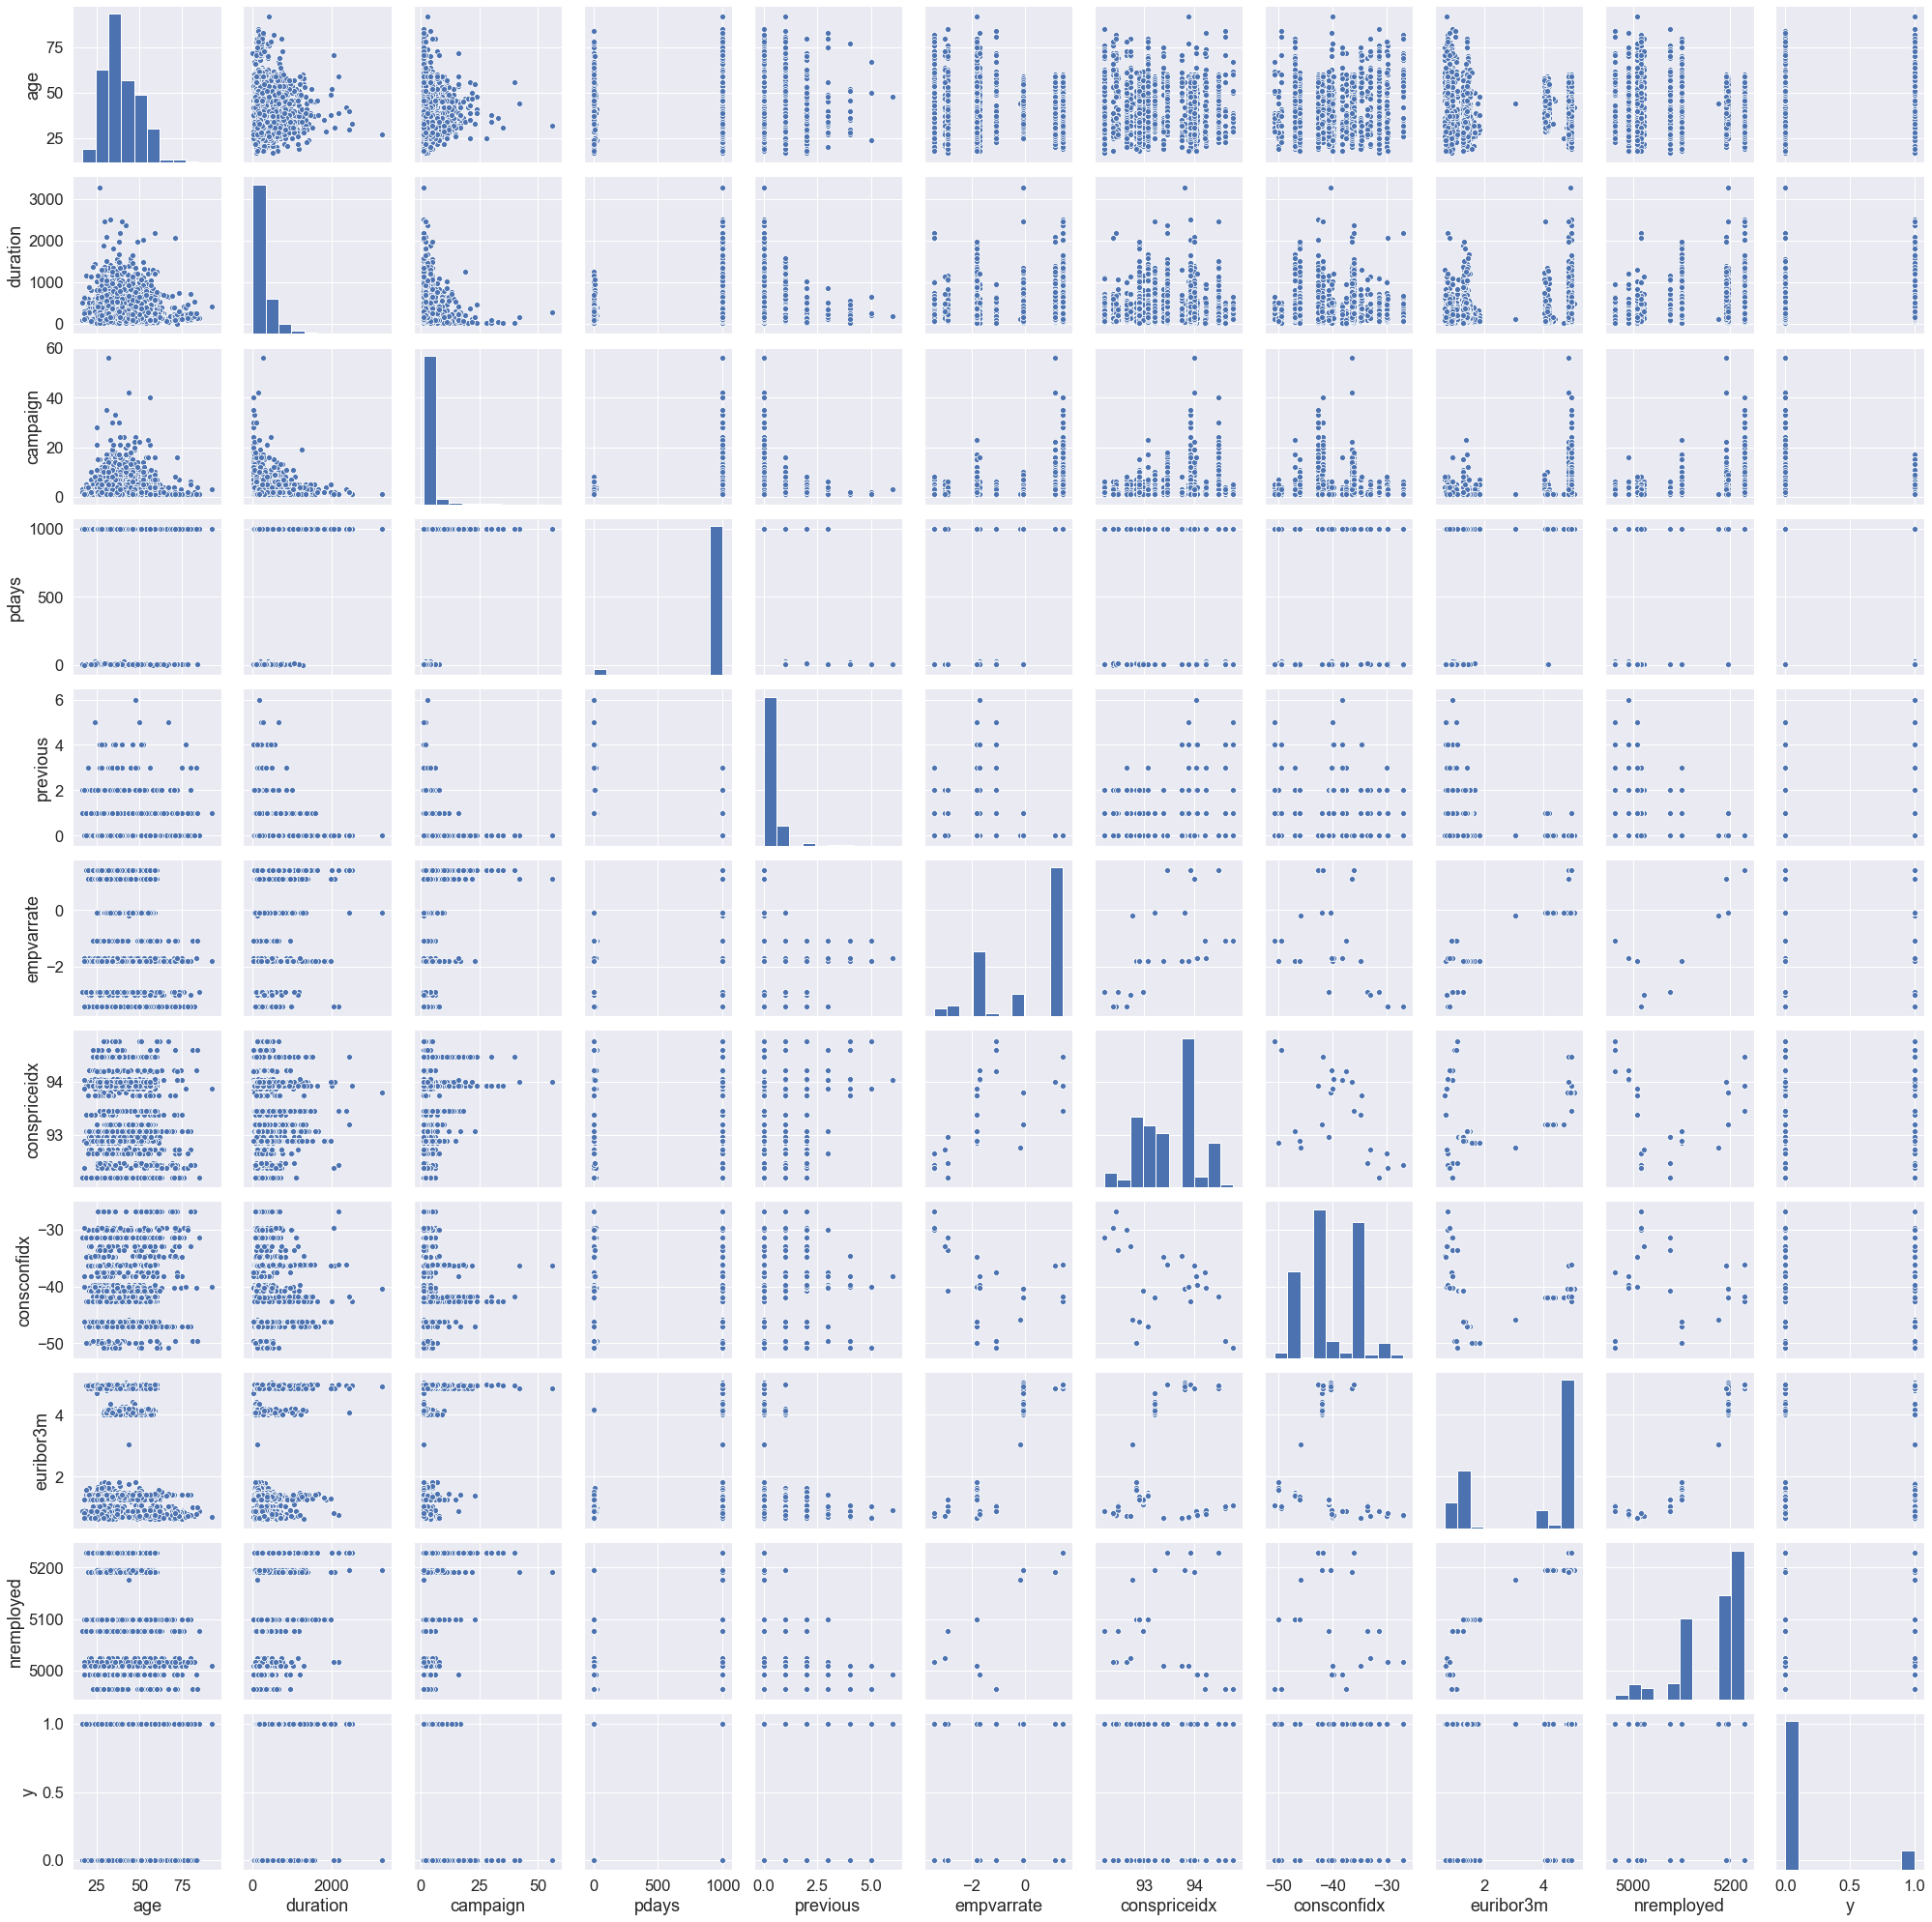

In [13]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

In [14]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'dayofweek', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'empvarrate', 'conspriceidx', 'consconfidx',
       'euribor3m', 'nremployed', 'y'],
      dtype='object')

In [15]:
df = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'dayofweek',
        'campaign', 'pdays','previous', 'poutcome','empvarrate', 'conspriceidx','consconfidx','y']]

In [16]:
df

,age,job,marital,education,default,housing,loan,contact,month,dayofweek,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,y
0,52,admin,single,university.degree,unknown,unknown,unknown,cellular,aug,wed,3,999,0,nonexistent,1.4,93.444,-36.1,0
1,49,blue-collar,divorced,high.school,no,no,yes,telephone,may,mon,2,999,0,nonexistent,1.1,93.994,-36.4,0
2,25,blue-collar,single,basic.9y,no,yes,yes,cellular,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,0
3,27,admin,single,university.degree,no,no,no,telephone,oct,tue,1,999,0,nonexistent,-0.1,93.798,-40.4,1
4,44,admin,married,university.degree,no,yes,no,cellular,aug,wed,1,999,0,nonexistent,-2.9,92.201,-31.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,37,technician,divorced,professional.course,no,yes,no,cellular,aug,tue,2,999,0,nonexistent,1.4,93.444,-36.1,0
4996,39,blue-collar,divorced,high.school,no,yes,yes,telephone,may,tue,3,999,0,nonexistent,1.1,93.994,-36.4,0
4997,28,services,single,professional.course,no,no,no,telephone,may,thu,2,999,0,nonexistent,-1.8,92.893,-46.2,0
4998,32,admin,single,university.degree,unknown,no,no,cellular,aug,tue,5,999,0,nonexistent,1.4,93.444,-36.1,0


### Treat Missing Values

In [17]:
df.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
housing         0
loan            0
contact         0
month           0
dayofweek       0
campaign        0
pdays           0
previous        0
poutcome        0
empvarrate      0
conspriceidx    0
consconfidx     0
y               0
dtype: int64

### Treat Duplicate Values

In [18]:
df.duplicated(keep='first').sum()

326

### Perform One-Hot Encoding

In [19]:
df2 = pd.get_dummies(df, drop_first=True)

In [20]:
df2

,age,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,dayofweek_mon,dayofweek_thu,dayofweek_tue,dayofweek_wed,poutcome_nonexistent,poutcome_success
0,52,3,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,49,2,999,0,1.1,93.994,-36.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,25,2,999,0,1.4,93.918,-42.7,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
3,27,1,999,0,-0.1,93.798,-40.4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,44,1,999,0,-2.9,92.201,-31.4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,37,2,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4996,39,3,999,0,1.1,93.994,-36.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4997,28,2,999,0,-1.8,92.893,-46.2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4998,32,5,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [21]:
df2.columns

Index(['age', 'campaign', 'pdays', 'previous', 'empvarrate', 'conspriceidx',
       'consconfidx', 'y', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'dayofweek_mon', 'dayofweek_thu', 'dayofweek_tue', 'dayofweek_wed',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [22]:
df2 = df2[['age', 'campaign', 'pdays', 'previous', 'empvarrate', 'conspriceidx',
       'consconfidx','job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'dayofweek_mon', 'dayofweek_thu', 'dayofweek_tue', 'dayofweek_wed',
       'poutcome_nonexistent', 'poutcome_success','y']]

In [23]:
df2

,age,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,dayofweek_mon,dayofweek_thu,dayofweek_tue,dayofweek_wed,poutcome_nonexistent,poutcome_success,y
0,52,3,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,49,2,999,0,1.1,93.994,-36.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,25,2,999,0,1.4,93.918,-42.7,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
3,27,1,999,0,-0.1,93.798,-40.4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
4,44,1,999,0,-2.9,92.201,-31.4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,37,2,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4996,39,3,999,0,1.1,93.994,-36.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4997,28,2,999,0,-1.8,92.893,-46.2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
4998,32,5,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


### Create and save processed dataset

In [24]:
#df2.to_csv("tele.csv",index=False)

In [25]:
df2.shape

(5000, 50)

### Train Test Split

In [26]:
X = df2.iloc[:,0:49]
y = df2.iloc[:,49]

In [27]:
X

,age,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,dayofweek_mon,dayofweek_thu,dayofweek_tue,dayofweek_wed,poutcome_nonexistent,poutcome_success
0,52,3,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,49,2,999,0,1.1,93.994,-36.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,25,2,999,0,1.4,93.918,-42.7,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
3,27,1,999,0,-0.1,93.798,-40.4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,44,1,999,0,-2.9,92.201,-31.4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,37,2,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4996,39,3,999,0,1.1,93.994,-36.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4997,28,2,999,0,-1.8,92.893,-46.2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4998,32,5,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [28]:
y

0       0
1       0
2       0
3       1
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    1
Name: y, Length: 5000, dtype: int64

### Treat Imbalance Data

In [29]:
y.value_counts()

0    4409
1     591
Name: y, dtype: int64

In [30]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [31]:
new_X, new_y = ros.fit_resample(X, y)

In [32]:
new_y.value_counts()

1    4409
0    4409
Name: y, dtype: int64

In [33]:
new_X

,age,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,dayofweek_mon,dayofweek_thu,dayofweek_tue,dayofweek_wed,poutcome_nonexistent,poutcome_success
0,52,3,999,0,1.4,93.444,-36.1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,49,2,999,0,1.1,93.994,-36.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,25,2,999,0,1.4,93.918,-42.7,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
3,27,1,999,0,-0.1,93.798,-40.4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,44,1,999,0,-2.9,92.201,-31.4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8813,58,1,999,0,-0.1,93.200,-42.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
8814,32,2,999,0,-1.8,93.749,-34.6,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
8815,34,1,10,2,-1.7,94.027,-38.3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8816,54,2,999,0,1.1,93.994,-36.4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [34]:
new_X.values, new_y.values

(array([[ 52.,   3., 999., ...,   1.,   1.,   0.],
        [ 49.,   2., 999., ...,   0.,   1.,   0.],
        [ 25.,   2., 999., ...,   1.,   1.,   0.],
        ...,
        [ 34.,   1.,  10., ...,   1.,   0.,   0.],
        [ 54.,   2., 999., ...,   1.,   1.,   0.],
        [ 28.,   1., 999., ...,   0.,   0.,   0.]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.3, random_state=0)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6172, 49), (2646, 49), (6172,), (2646,))

### Feature Scaling

In [37]:
X_train

array([[ 59.,   1., 999., ...,   0.,   0.,   0.],
       [ 44.,   2., 999., ...,   0.,   0.,   0.],
       [ 36.,   1., 999., ...,   0.,   1.,   0.],
       ...,
       [ 52.,   5., 999., ...,   1.,   1.,   0.],
       [ 59.,   1., 999., ...,   0.,   0.,   0.],
       [ 23.,   2., 999., ...,   0.,   1.,   0.]])

In [38]:
scaler = StandardScaler()

In [39]:
X_train_scaled = scaler.fit_transform(X_train)

In [40]:
X_test_scaled = scaler.transform(X_test)

In [41]:
X_train_scaled

array([[ 1.65324083, -0.55085781,  0.35245253, ..., -0.54664573,
        -1.89893922, -0.33924301],
       [ 0.35148082, -0.14615665,  0.35245253, ..., -0.54664573,
        -1.89893922, -0.33924301],
       [-0.34279118, -0.55085781,  0.35245253, ..., -0.54664573,
         0.5266098 , -0.33924301],
       ...,
       [ 1.04575283,  1.06794681,  0.35245253, ...,  1.82933837,
         0.5266098 , -0.33924301],
       [ 1.65324083, -0.55085781,  0.35245253, ..., -0.54664573,
        -1.89893922, -0.33924301],
       [-1.47098318, -0.14615665,  0.35245253, ..., -0.54664573,
         0.5266098 , -0.33924301]])

In [42]:
X_test_scaled

array([[ 1.91359283, -0.55085781,  0.35245253, ..., -0.54664573,
        -1.89893922, -0.33924301],
       [-1.21063118, -0.14615665,  0.35245253, ..., -0.54664573,
         0.5266098 , -0.33924301],
       [-0.08243918, -0.14615665,  0.35245253, ..., -0.54664573,
         0.5266098 , -0.33924301],
       ...,
       [-0.16922318, -0.14615665,  0.35245253, ..., -0.54664573,
         0.5266098 , -0.33924301],
       [-0.77671118, -0.55085781,  0.35245253, ..., -0.54664573,
         0.5266098 , -0.33924301],
       [-1.99168718, -0.14615665,  0.35245253, ..., -0.54664573,
        -1.89893922, -0.33924301]])

### Model Training

### Using XGBoost (Scikit-Learn)

In [43]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [44]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.294407
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.294407
[2]	validation_0-error:0.295162
[3]	validation_0-error:0.295162
[4]	validation_0-error:0.294407
[5]	validation_0-error:0.292139
[6]	validation_0-error:0.295162
[7]	validation_0-error:0.295162
[8]	validation_0-error:0.291005
[9]	validation_0-error:0.291005
[10]	validation_0-error:0.291005
[11]	validation_0-error:0.291005
[12]	validation_0-error:0.291005
[13]	validation_0-error:0.290627
[14]	validation_0-error:0.290249
[15]	validation_0-error:0.290249
[16]	validation_0-error:0.290249
[17]	validation_0-error:0.290249
[18]	validation_0-error:0.290249
[19]	validation_0-error:0.289872
[20]	validation_0-error:0.28836
[21]	validation_0-error:0.285714
[22]	validation_0-error:0.285714
[23]	validation_0-error:0.283447
[24]	validation_0-error:0.286848
[25]	validation_0-error:0.286092
[26]	validation_0-error:0.285714
[27]	validation_0-error:0.285336
[28]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
y_pred = xgbmodel.predict(X_test_scaled)

In [46]:
y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

### Model Evaluation

In [47]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[988, 324],
       [401, 933]], dtype=int64)

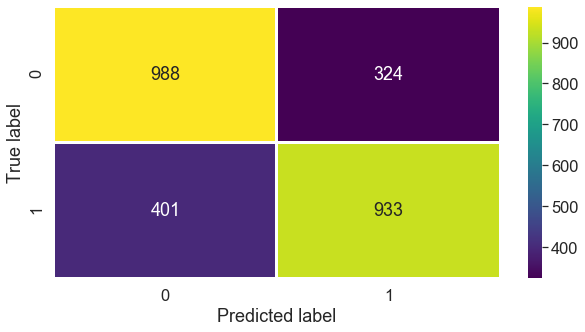

In [48]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

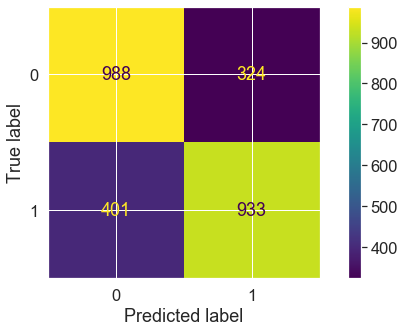

In [49]:
fig , ax = plt.subplots(figsize=(10,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [50]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1312
           1       0.74      0.70      0.72      1334

    accuracy                           0.73      2646
   macro avg       0.73      0.73      0.73      2646
weighted avg       0.73      0.73      0.73      2646



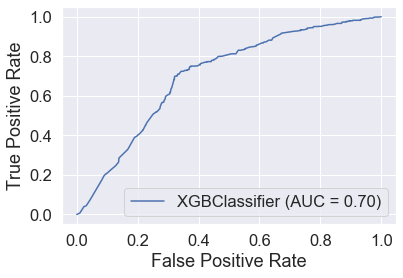

In [51]:
plot_roc_curve(xgbmodel,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [52]:
X.columns

Index(['age', 'campaign', 'pdays', 'previous', 'empvarrate', 'conspriceidx',
       'consconfidx', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'dayofweek_mon', 'dayofweek_thu', 'dayofweek_tue', 'dayofweek_wed',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [53]:
xgbmodel.get_booster().feature_names = ['age', 'campaign', 'pdays', 'previous', 'empvarrate', 'conspriceidx',
       'consconfidx', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'dayofweek_mon', 'dayofweek_thu', 'dayofweek_tue', 'dayofweek_wed',
       'poutcome_nonexistent', 'poutcome_success']

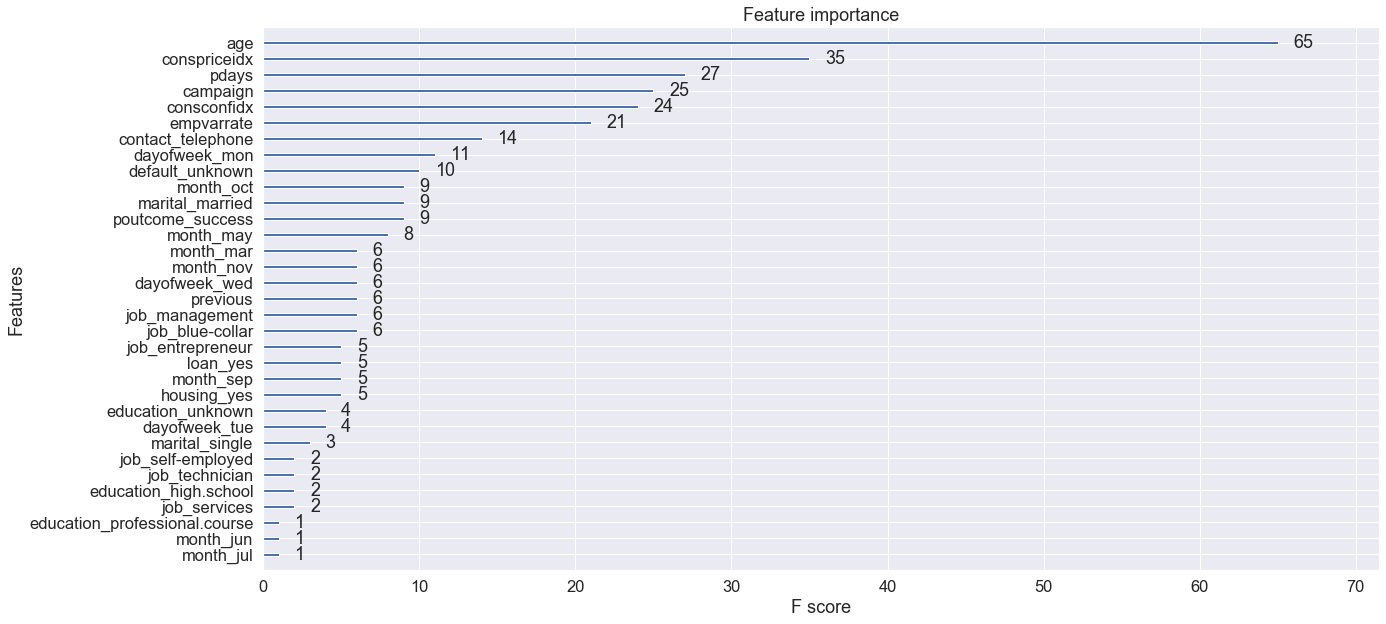

In [54]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

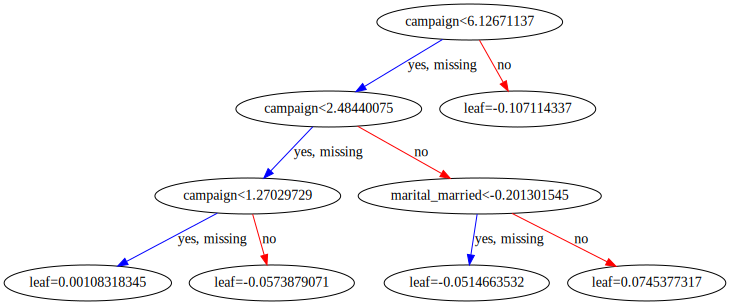

In [55]:
xgb.to_graphviz(xgbmodel,num_trees=50)

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [56]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


In [57]:
cv.mean()

0.8868

### Save the Model

In [59]:
filename = 'tele.sav'
dump(xgbmodel,open(filename,'wb'))